## How to Train the Adversarial Detection Model

### 0. Imports

In [1]:
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

#Lib Imports
import torch
import shutil
import os 
import engines.KataGo.python.katago.train.load_model as load_model
import json
import gzip
import numpy as np
from pathlib import Path
import pandas as pd
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt

#Submodule Imports
from engines.KataGo.python.katago.game.board import Board
from engines.KataGo.python.katago.game.gamestate import GameState
from engines.KataGo.python.katago.game.features import Features

#SRC Imports
from adv_detection.sgf_reader import SGFReader as reader
from adv_detection.probe import Probe
from adv_detection.adv_det_train import Training_Loop
from adv_detection.adv_det_dataset import Adversarial_Detection_Dataset as adv_dataset
from adv_detection.adv_det_model import Model
from adv_detection.adv_det_eval import Evaluation

/Users/yz24943/Documents/Research/Summer_Project/Go_Adversarial_Policy_Defence/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/Users/yz24943/Documents/Research/Summer_Project/Go_Adversarial_Policy_Defence/venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type

### 1. Create Dataset

##### 1.1 Instance the victim model
##### This lets us see what the available block outputs are see we can decide which ones to use to create the dataset.

In [8]:

#Where the file path to the victim model is set
nn_chkpt = '../../models/kataGo/ckpt_files/kata1-b18c384nbt-s9996604416-d4316597426/model.ckpt'
kata_model, kata_swa_model, other_state_dict = load_model.load_model(nn_chkpt, use_swa=True, device = torch.device("cpu"))

#This defines which conv blocks outputs are stored
blocks = np.array(kata_model.block_kind)
block_extra_outputs = [layer_name + '.out' for layer_name in blocks[0:,0]]

print(block_extra_outputs)

['rconv1.out', 'rconv2.out', 'rconv3.out', 'rconv4.out', 'rconv5.out', 'rconv6.out', 'rconv7.out', 'rconv8.out', 'rconv9.out', 'rconv10.out', 'rconv11.out', 'rconv12.out', 'rconv13.out', 'rconv14.out', 'rconv15.out', 'rconv16.out', 'rconv17.out', 'rconv18.out']


#### 1.2 Instance the Probe and Batch the Data

In [ ]:
#File directories and setting seed
adv_data_dir = 'detection_dataset/Game_Data/may-big-matchup/Adversarial_Policies'
non_adv_data_dir = 'detection_dataset/Game_Data/may-big-matchup/Non-Adv_Policies'
seed = 42

#Instances the Probe
control_probe = Probe(adv_data_dir, non_adv_data_dir, seed)

#Splits the data into batches with equal split between games
batch_size = 100
batched_data = control_probe.equal_batch_data(batch_size)

#### 1.3 Probe the Batches
#### This Takes 30 - 40 minutes per 100 games, and can take up a lot of space

In [6]:
#Creating a separate Eval Set so That Games Do not appear in Both Sets
train_data_dir_path = 'detection_dataset/Probe_Data/train'
eval_data_dir_path = 'detection_dataset/Probe_Data/eval'

model_name = 'may24_victim'
#Determines which convolutional block outputs are stored in this case we are using the last layer output
probe_layers = ['rconv18.out']

train_batch_num = 0
eval_batch_num = 1

Probe.probe_batch(Probe, nn_chkpt, model_name, probe_layers, batched_data, train_batch_num, train_data_dir_path)
Probe.probe_batch(Probe, nn_chkpt, model_name, probe_layers, batched_data, eval_batch_num, eval_data_dir_path)

Directory '../../detection_dataset/Probe_Data/train/may24_victim/rconv18' created successfully.
Directory '../../detection_dataset/Probe_Data/eval/may24_victim/rconv18' created successfully.


#### 1.4 Have a Look at the MetaData if you Like
#### Each directory you store a probed batch in has it's own meta_data.json file.

In [ ]:

eval_meta_data_file = 'detection_dataset/Probe_Data/eval/may24_victim/meta_data.json'

with open(eval_meta_data_file) as json_data:
    meta_data  = json.load(json_data)
    json_data.close()
    print('meta_data has two keys:')
    for key in meta_data.keys():
        print('     ' + str(key))

    print('\nThe model data, covers the inofrmation about the model which was probed: ')
    for key in meta_data['model data'].keys():
        print('     ' + str(key))

    print('\nThe game data, holds information on each game in the directory: ')
    print('It contains the nicknames of the models, the version numbers and the label')
    for key in meta_data['game data'][42:52]:
        print('     ' + str(key))

    

### 2. Train the Model

In [2]:
#Train Parametres
lr = 0.0001
epochs = 1
batch_size = 128

train_data_dir_path = 'detection_dataset/Probe_Data/train/may24_victim/rconv18'
eval_data_dir_path = 'detection_dataset/Probe_Data/eval/may24_victim/rconv18'

#Instancing the training Loop 
train_loop = Training_Loop(train_data_dir_path, batch_size, epochs, lr)

train_loop.train(epochs)

#You can train using wandb to log the trianing
#train_loop.train_and_log(epochs, 'test_run', 'API KEY')

/Users/yz24943/Documents/Research/Summer_Project/Go_Adversarial_Policy_Defence/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/Users/yz24943/Documents/Research/Summer_Project/Go_Adversarial_Policy_Defence/src/adv_detection/adv_det_train.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/Users/yz24943/Documents/Research/Summer_Project/Go_Adversarial_Policy_Defence/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directl

Acc: 0.9922580645161291


### 3. Evaluate the Model

In [2]:
model = torch.load('../../models/detection/model_0.chkpt', weights_only=False)

eval = Evaluation(model, 'detection_dataset/Probe_Data/eval/may24_victim/rconv18', 10, 0)

acc = eval.evaluate_model()

pol_eval = eval.evaluate_per_policy()

move_eval = eval.evaluate_per_move()

class_eval = eval.evaluate_per_class()

print('Accuracy: ' + str(acc))
print('Positive Acc: ' + str(class_eval[1]))
print('Negative Acc: ' + str(class_eval[0]))

Accuracy: 0.9959514170040485
Positive Acc: 0.9993279569892473
Negative Acc: 0.9908350305498982


#### 3.1 Graph Results

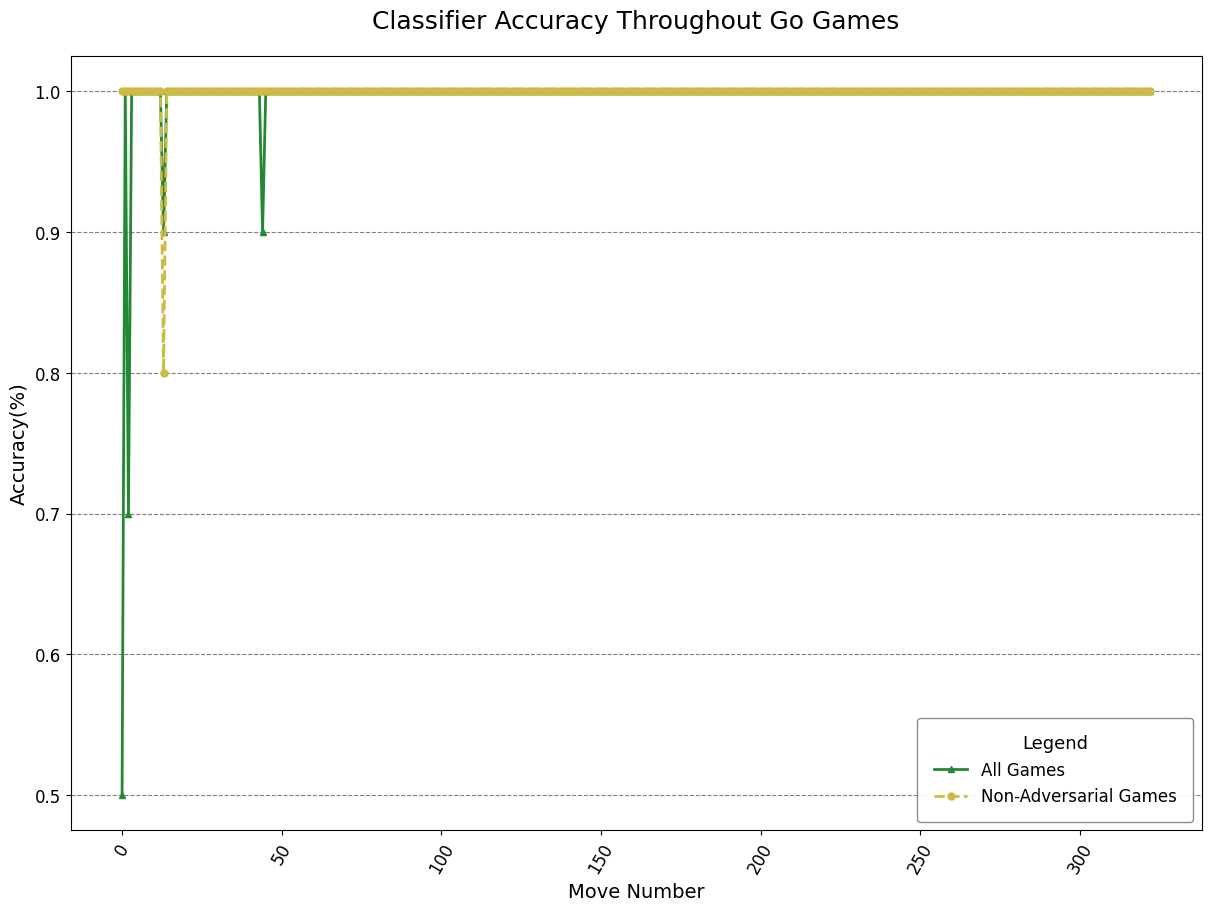

In [7]:
colours = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377', '#BBBBBB']

both_x, both_y = move_eval[0].keys(), move_eval[0].values()
adv_x, adv_y = move_eval[1].keys(), move_eval[1].values()
non_x, non_y = move_eval[1].keys(), move_eval[1].values()

fig, ax = plt.subplots(figsize = (12,9), constrained_layout=True)

ax.plot(both_x, both_y, color= colours[2], linewidth=2, marker='^', markersize=5, label = 'All Games')
#ax.plot(adv_x, adv_y, color= colours[0], linewidth=2, marker='o', markersize=5, linestyle = 'dashed', label = 'Adversarial Games')
ax.plot(non_x, non_y, color= colours[3], linewidth=2, marker='o', markersize=5, linestyle = 'dashed', label = 'Non-Adversarial Games')
#ax.set_facecolor('#e7e7e7')

ax.set_title('Classifier Accuracy Throughout Go Games', fontsize=18, pad=20)

ax.legend(    
    title='Legend',
    title_fontsize=13,
    fontsize=12,
    loc='lower right',
    frameon=True,
    facecolor='white',
    edgecolor='gray',
    fancybox=True,
    framealpha=0.9,
    borderpad=1,
    labelspacing=0.5
    )

ax.set_xlabel('Move Number', fontsize=14)
ax.set_ylabel('Accuracy(%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.yaxis.grid(color = 'gray', linestyle = 'dashed')
ax.tick_params("x", rotation=60)

plt.show()